In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from pathlib import Path

from gptchem.evaluator import find_learning_curve_intersection, fit_learning_curve, lc
from gptchem.plotsettings import *
from gptchem.settings import (
    ONE_COL_GOLDEN_RATIO_HEIGHT_INCH,
    ONE_COL_WIDTH_INCH,
    TWO_COL_GOLDEN_RATIO_HEIGHT_INCH,
)

from gptchem.representation import smiles_to_canoncial

%matplotlib inline

In [61]:
all_res = glob('out/**/*.pkl')

In [62]:
loaded_res = []

for res in all_res:
    loaded = load_pickle(res)
    train_json = os.path.join(Path(res).parent, 'train.jsonl')
    loaded_json = pd.read_json(train_json, lines=True)
    loaded_json['canonical'] = loaded_json['representation'].apply(smiles_to_canoncial)
    loaded["real_train_size_can"] = len(loaded_json["canonical"].value_counts())
    loaded["real_train_size"] = min(
        [10, 20, 50, 100, 200, 500],
        key=lambda x: abs(x - loaded["real_train_size_can"]),
    )
    loaded_res.append(loaded)

In [63]:
loaded_res = pd.DataFrame(loaded_res)

In [68]:
no_augmentation_frame = loaded_res[loaded_res["augmentation_rounds"] == 0]
augmentation_frame = loaded_res[loaded_res["augmentation_rounds"] > 0]

In [70]:
augmented_grouped = augmentation_frame.groupby(['num_classes', 'deduplicate', 'augmentation_rounds', 'real_train_size']).agg(['mean', 'std', sem])

/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(

In [71]:
no_augmented_grouped = no_augmentation_frame.groupby(['num_classes',  'real_train_size']).agg(['mean', 'std', sem])

/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(

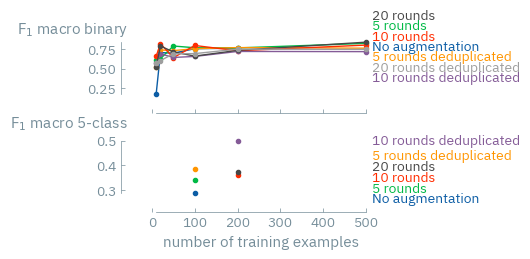

In [108]:
fig, ax = plt.subplots(2,1, figsize=(ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex=True)

metric = 'f1_macro'

ax[0].plot(
    no_augmented_grouped.loc[2].index,
    no_augmented_grouped.loc[2][metric]["mean"],
    marker="o",
    label="No augmentation",
)

ax[0].fill_between(
    no_augmented_grouped.loc[2].index,
    no_augmented_grouped.loc[2][metric]["mean"]
    - no_augmented_grouped.loc[2][metric]["sem"],
    no_augmented_grouped.loc[2][metric]["mean"]
    + no_augmented_grouped.loc[2][metric]["sem"],
    alpha=0.2,
)

for num_rounds in [5, 10, 20]:
    ax[0].plot(
        augmented_grouped.loc[2, False, num_rounds].index,
        augmented_grouped.loc[2, False, num_rounds][metric]["mean"],
        marker="o",
        label="{} rounds".format(num_rounds),
    )
    ax[0].fill_between(
        augmented_grouped.loc[2, False, num_rounds].index,
        augmented_grouped.loc[2, False, num_rounds][metric]["mean"]
        - augmented_grouped.loc[2, False, num_rounds][metric]["sem"],
        augmented_grouped.loc[2, False, num_rounds][metric]["mean"]
        + augmented_grouped.loc[2, False, num_rounds][metric]["sem"],
        alpha=0.2,
    )

    ax[0].plot(
        augmented_grouped.loc[2, True, num_rounds].index,
        augmented_grouped.loc[2, True, num_rounds][metric]["mean"],
        marker="o",
        label="{} rounds deduplicated".format(num_rounds),
    )
    ax[0].fill_between(
        augmented_grouped.loc[2, True, num_rounds].index,
        augmented_grouped.loc[2, True, num_rounds][metric]["mean"]
        - augmented_grouped.loc[2, True, num_rounds][metric]["sem"],
        augmented_grouped.loc[2, True, num_rounds][metric]["mean"]
        + augmented_grouped.loc[2, True, num_rounds][metric]["sem"],
        alpha=0.2,
    )


ax[1].plot(
    no_augmented_grouped.loc[5].index,
    no_augmented_grouped.loc[5][metric]["mean"],
    marker="o",
    label="No augmentation",
)

ax[1].fill_between(
    no_augmented_grouped.loc[5].index,
    no_augmented_grouped.loc[5][metric]["mean"]
    - no_augmented_grouped.loc[5][metric]["sem"],
    no_augmented_grouped.loc[5][metric]["mean"]
    + no_augmented_grouped.loc[5][metric]["sem"],
    alpha=0.2,
)

for num_rounds in [5, 10, 20]:
    try:
        ax[1].plot(
            augmented_grouped.loc[5, False, num_rounds].index,
            augmented_grouped.loc[5, False, num_rounds][metric]["mean"],
            marker="o",
            label="{} rounds".format(num_rounds),
        )
        ax[1].fill_between(
            augmented_grouped.loc[5, False, num_rounds].index,
            augmented_grouped.loc[5, False, num_rounds][metric]["mean"]
            - augmented_grouped.loc[5, False, num_rounds][metric]["sem"],
            augmented_grouped.loc[5, False, num_rounds][metric]["mean"]
            + augmented_grouped.loc[5, False, num_rounds][metric]["sem"],
            alpha=0.2,
        )

        ax[1].plot(
            augmented_grouped.loc[5, True, num_rounds].index,
            augmented_grouped.loc[5, True, num_rounds][metric]["mean"],
            marker="o",
            label="{} rounds deduplicated".format(num_rounds),
        )
        ax[1].fill_between(
            augmented_grouped.loc[5, True, num_rounds].index,
            augmented_grouped.loc[5, True, num_rounds][metric]["mean"]
            - augmented_grouped.loc[5, True, num_rounds][metric]["sem"],
            augmented_grouped.loc[5, True, num_rounds][metric]["mean"]
            + augmented_grouped.loc[5, True, num_rounds][metric]["sem"],
            alpha=0.2,
        )
    except KeyError:
        pass


matplotx.line_labels(ax[0])
matplotx.line_labels(ax[1])

ylabel_top(r'F$_1$ macro binary', ax[0])
ylabel_top(r'F$_1$ macro 5-class', ax[1], y_pad=0.4)

range_frame(
    ax[0],
    np.array([10, 500]),
    np.array([augmented_grouped.loc[2][metric]['mean'].min(), augmented_grouped.loc[2][metric]['mean'].max(), no_augmented_grouped.loc[2][metric]['mean'].min(), no_augmented_grouped.loc[2][metric]['mean'].max()])
)


range_frame(
    ax[1],
    np.array([10, 500]),
    np.array([augmented_grouped.loc[5][metric]['mean'].min(), augmented_grouped.loc[5][metric]['mean'].max(), no_augmented_grouped.loc[5][metric]['mean'].min(), no_augmented_grouped.loc[5][metric]['mean'].max()])
)

plt.subplots_adjust(hspace=0.6, top=1, bottom=0.2)

ax[1].set_xlabel("number of training examples")

fig.savefig('lc_esol_smiles_aug.pdf', bbox_inches='tight')